In [1]:
import os
import sys
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import itertools
import joblib
import sklearn

from datetime import date, timedelta
from matplotlib import style

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

from ta import add_all_ta_features

from helpers import Featurizer, normalize_price, plot_confusion_matrix

warnings.simplefilter("ignore")
style.use('ggplot')

security = '^IBEX'

In [2]:
today = date.today() + timedelta(days=1) # date(2019, 11, 22) #
start_date = '2001-07-01' # today - timedelta(days=150) # 
today

datetime.date(2020, 1, 10)

In [3]:
ticker = yf.Ticker(security)
df = ticker.history(start=start_date, end=today.strftime('%Y-%m-%d'), interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-07-02,8878.391790,9083.991201,8827.691644,9073.291016,88000,0,0
2001-07-03,9073.290960,9104.891515,8954.691466,9015.891602,93600,0,0
2001-07-04,8994.191298,8994.191298,8850.891635,8884.991211,70400,0,0
2001-07-05,8884.991114,8893.691300,8761.491237,8787.590820,84200,0,0
2001-07-06,8738.790771,8738.790771,8456.391649,8501.891602,146400,0,0
...,...,...,...,...,...,...,...
2020-01-03,9631.200195,9650.700195,9581.200195,9646.599609,135130000,0,0
2020-01-06,9585.400391,9618.200195,9492.700195,9600.900391,103520400,0,0
2020-01-07,9623.099609,9657.900391,9557.900391,9579.799805,133476100,0,0


In [4]:
df['2010-08-22':'2010-08-31']['Volume'].mean()

143721142.85714287

In [5]:
alpha = df['2010-08-22':'2010-08-31']['Volume'].mean()/df[:'2010-08-22']['Volume'].mean()
alpha

817.6859496335845

In [6]:
# Desechamos los datos previos al 1 de julio de 2001
df = df['2001-07-01':]

# Alteramos la proporción del volumen de negociación
mask = (df.index >= '2001-07-01') & (df.index < '2010-08-22')
df['Volume'].mask(mask, df['Volume'] * alpha, inplace=True)
df['Volume'].replace(0, np.nan, inplace=True)
df['Volume'].interpolate(method='linear', inplace=True)

Text(0, 0.5, 'Volumen')

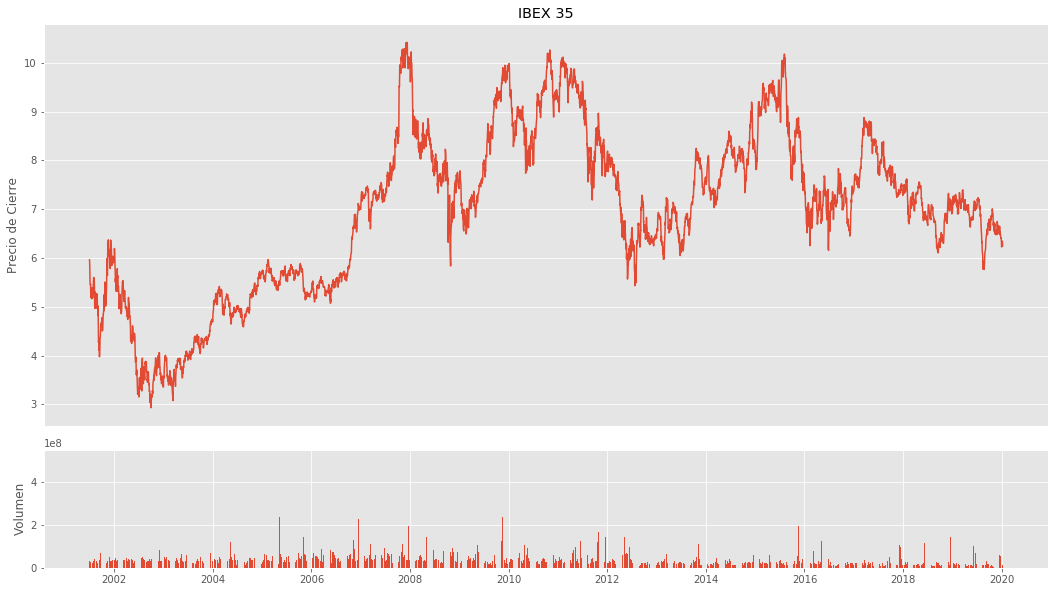

In [31]:
# Visualizamos los datos para ver cómo quedan
plt.figure(figsize=(18,10))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(df.index, df['Close'])
bottom.bar(df.index, df['Volume']) 

top.axes.get_xaxis().set_visible(False)
top.set_title('IBEX 35')
top.set_ylabel('Precio de Cierre')
bottom.set_ylabel('Volumen')

In [7]:
ts = df[:-30]

In [8]:
ts

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2001-07-02,8878.391790,9083.991201,8827.691644,9073.291016,7.195636e+07,0,0
2001-07-03,9073.290960,9104.891515,8954.691466,9015.891602,7.653540e+07,0,0
2001-07-04,8994.191298,8994.191298,8850.891635,8884.991211,5.756509e+07,0,0
2001-07-05,8884.991114,8893.691300,8761.491237,8787.590820,6.884916e+07,0,0
2001-07-06,8738.790771,8738.790771,8456.391649,8501.891602,1.197092e+08,0,0
...,...,...,...,...,...,...,...
2019-11-19,9288.000000,9327.500000,9234.400391,9259.200195,1.217961e+08,0,0
2019-11-20,9223.700195,9240.400391,9165.400391,9225.400391,1.398992e+08,0,0
2019-11-21,9175.099609,9223.099609,9152.099609,9214.000000,1.420038e+08,0,0


In [50]:
featurizer = Featurizer(ts)
featurizer.add_features(forecast_horizon=5, with_ndays_lag=0)

In [51]:
X_train, y_train, X_test, y_test = featurizer.crossval_split(split_session=30, predict_day=1)
X_train

,Open,High,Low,Close,Volume,Dividends,Stock Splits,week_day,month_day,month,...,low_pct_change,low_log_ret,volume_pct_change,volume_log_ret,closet1_opent_diff,closet1_opent_trend,close_trend,percent_b,bandwidth_b,percentb_signal
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-03,9073.290960,9104.891515,8954.691466,9015.891602,7.653540e+07,0,0,1,3,7,...,0.014387,0.014284,0.063636,0.061694,-0.000056,-1,-1,0.323223,9124.775313,0
2001-07-04,8994.191298,8994.191298,8850.891635,8884.991211,5.756509e+07,0,0,2,4,7,...,-0.011592,-0.011659,-0.247863,-0.284837,-21.700303,-1,-1,0.224384,9183.435059,0
2001-07-05,8884.991114,8893.691300,8761.491237,8787.590820,6.884916e+07,0,0,3,5,7,...,-0.010101,-0.010152,0.196023,0.179002,-0.000097,-1,-1,0.203353,9197.099626,0
2001-07-06,8738.790771,8738.790771,8456.391649,8501.891602,1.197092e+08,0,0,4,6,7,...,-0.034823,-0.035444,0.738717,0.553148,-48.800050,-1,-1,0.111271,9303.047502,0
2001-07-09,8501.891627,8577.090768,8344.591008,8526.191406,8.389458e+07,0,0,0,9,7,...,-0.013221,-0.013309,-0.299180,-0.355505,0.000025,1,0,0.218733,9281.096107,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-07,8954.700195,9046.299805,8930.400391,9044.099609,1.310803e+08,0,0,0,7,10,...,0.008105,0.008073,-0.118775,-0.126442,-7.099609,-1,0,0.398658,9256.885433,0
2019-10-08,9066.500000,9071.500000,8900.799805,8940.099609,1.403706e+08,0,0,1,8,10,...,-0.003315,-0.003320,0.070875,0.068476,22.400391,1,-1,0.146825,9260.703178,0
2019-10-09,8952.700195,9035.599609,8934.200195,8991.900391,1.036380e+08,0,0,2,9,10,...,0.003753,0.003745,-0.261683,-0.303382,12.600586,1,0,0.296918,9260.753156,0


In [52]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [53]:
tscv = featurizer.timeseries_cross_validator(X_train_scaled.shape[0], test_size=X_test_scaled.shape[0])

In [55]:
cls = SVC(C=2.0, kernel='linear', gamma='auto')
cls.fit(X_train_scaled, y_train)

y_hat = cls.predict(X_test_scaled)

f1 = f1_score(y_pred=y_hat, y_true=y_test)
accuracy = accuracy_score(y_pred=y_hat, y_true=y_test)
baccuracy = balanced_accuracy_score(y_pred=y_hat, y_true=y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Balanced Accuracy: %.2f%%" % (baccuracy * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 63.33%
Balanced Accuracy: 65.18%
F1 Score: 70.27%


In [56]:
pd.DataFrame(
    confusion_matrix(y_pred=y_hat, y_true=y_test),
    columns=['Predicted Sell', 'Predicted Buy'],
    index=['True Sell', 'True Buy']
)

,Predicted Sell,Predicted Buy
True Sell,6,10
True Buy,1,13


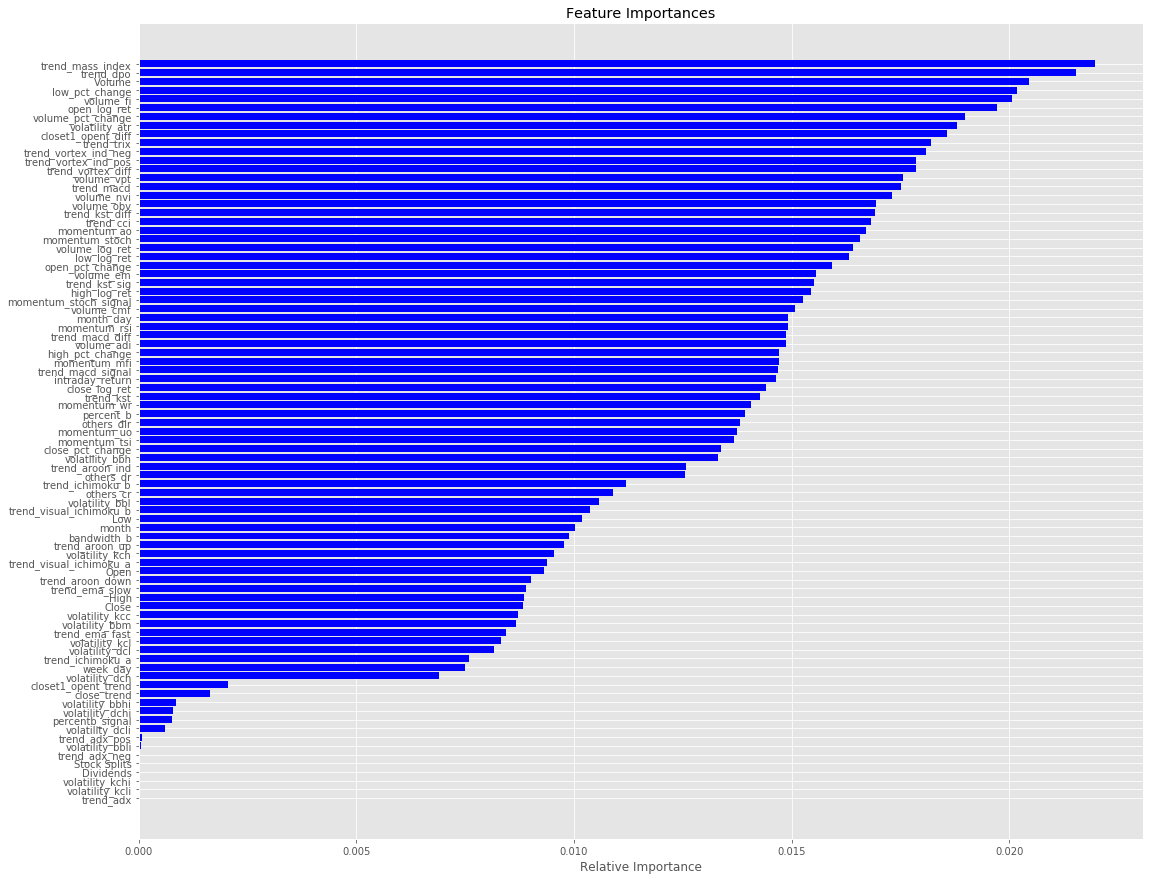

In [57]:
rforest = RandomForestClassifier()
rforest.fit(X_train, y_train)

y_hat = rforest.predict(X_test)

features = X_train.columns
importances = rforest.feature_importances_
indices = np.argsort(importances)

plt.rcParams["figure.figsize"] = (18,15)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [58]:
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.4,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'colsample_bynode': 0.5,
    'random_state': 5
}

xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)

y_hat = xgb.predict(X_test)

f1 = f1_score(y_pred=y_hat, y_true=y_test)
accuracy = accuracy_score(y_pred=y_hat, y_true=y_test)
baccuracy = balanced_accuracy_score(y_pred=y_hat, y_true=y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Balanced Accuracy: %.2f%%" % (baccuracy * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 73.33%
Balanced Accuracy: 72.32%
F1 Score: 66.67%


In [60]:
from numpy import sort

best_threshold = 0
last_accuracy = 0
last_f1score = 0
last_logloss = np.inf
thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
    if thresh > 0:
        # select features using threshold
        selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier(**params)
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        predictions = selection_model.predict(select_X_test)
        accuracy = accuracy_score(y_test, predictions)
        baccuracy = balanced_accuracy_score(y_test, predictions)
        logloss = log_loss(y_test, predictions)
        f1score = f1_score(y_test, predictions)

        print("Thresh=%.10f, n=%d, Accuracy: %.2f%%, Balanced Acc.: %.2f%%, Log loss: %.5f, F1: %.2f%%." % (
          thresh, select_X_train.shape[1], accuracy*100.0, baccuracy*100, logloss, f1score*100.0
        ))

        if logloss <= last_logloss:
            last_logloss = logloss
            last_accuracy = accuracy
            last_f1score = f1score
            best_threshold = thresh

Thresh=0.0083556296, n=74, Accuracy: 50.00%, Balanced Acc.: 49.11%, Log loss: 17.26955, F1: 40.00%.
Thresh=0.0087406049, n=73, Accuracy: 63.33%, Balanced Acc.: 62.50%, Log loss: 12.66432, F1: 56.00%.
Thresh=0.0092450865, n=72, Accuracy: 50.00%, Balanced Acc.: 48.21%, Log loss: 17.26949, F1: 28.57%.
Thresh=0.0096603734, n=71, Accuracy: 50.00%, Balanced Acc.: 49.11%, Log loss: 17.26955, F1: 40.00%.
Thresh=0.0105239740, n=70, Accuracy: 46.67%, Balanced Acc.: 46.88%, Log loss: 18.42092, F1: 46.67%.
Thresh=0.0105683235, n=69, Accuracy: 50.00%, Balanced Acc.: 49.11%, Log loss: 17.26955, F1: 40.00%.
Thresh=0.0105917919, n=68, Accuracy: 43.33%, Balanced Acc.: 43.30%, Log loss: 19.57221, F1: 41.38%.
Thresh=0.0108559188, n=67, Accuracy: 63.33%, Balanced Acc.: 60.71%, Log loss: 12.66422, F1: 35.29%.
Thresh=0.0111689521, n=66, Accuracy: 43.33%, Balanced Acc.: 43.30%, Log loss: 19.57221, F1: 41.38%.
Thresh=0.0113273235, n=65, Accuracy: 46.67%, Balanced Acc.: 44.20%, Log loss: 18.42076, F1: 11.11%.


In [17]:
best_threshold

0.013006270548666227

In [18]:
thresh=best_threshold

selection = SelectFromModel(rforest, threshold=thresh, prefit=True)
X_train_thresh = selection.transform(X_train_scaled)
X_test_thresh = selection.transform(X_test_scaled)

In [33]:
cls = SVC(C=2.0, kernel='linear', gamma='auto')
cls.fit(X_train_thresh, y_train)

y_hat = cls.predict(X_test_thresh)

f1 = f1_score(y_pred=y_hat, y_true=y_test)
accuracy = accuracy_score(y_pred=y_hat, y_true=y_test)
baccuracy = balanced_accuracy_score(y_pred=y_hat, y_true=y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Balanced Accuracy: %.2f%%" % (baccuracy * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))

Accuracy: 60.00%
Balanced Accuracy: 61.16%
F1 Score: 64.71%


In [34]:
results = cross_val_score(cls, X_train_thresh, y_train, cv=tscv)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 51.44% (8.99%)


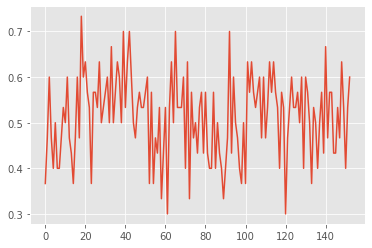

In [35]:
plt.plot(results)
plt.show()

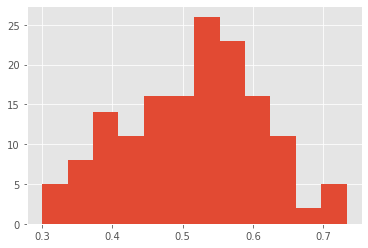

In [36]:
plt.hist(results, bins='auto')
plt.show()

In [37]:
# Hold-out Dataset
ho = df[-30:]
featurizer_ho = Featurizer(ho)
featurizer_ho.add_features(forecast_horizon=30, with_ndays_lag=0)

X_ho, y_ho = featurizer_ho.train_split()
#X_ho = X_ho[-28:]
#y_ho = y_ho[-28:]

X_ho

,Open,High,Low,Close,Volume,Dividends,Stock Splits,week_day,month_day,month,...,low_pct_change,low_log_ret,volume_pct_change,volume_log_ret,closet1_opent_diff,closet1_opent_trend,close_trend,percent_b,bandwidth_b,percentb_signal
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-27,9353.500000,9388.700195,9333.400391,9362.700195,135045800.0,0,0,2,27,11,...,0.004866,0.004855,-0.370964,-0.463567,28.700195,1,0,0.676777,9396.354983,0
2019-11-28,9353.599609,9373.099609,9343.799805,9359.000000,107163700.0,0,0,3,28,11,...,0.001114,0.001114,-0.206464,-0.231256,-9.100586,-1,-1,0.621636,9389.629225,0
2019-11-29,9334.500000,9404.500000,9312.500000,9352.000000,140835600.0,0,0,4,29,11,...,-0.003350,-0.003355,0.314210,0.273236,-24.500000,-1,-1,0.534652,9382.897841,0
2019-12-02,9367.200195,9390.900391,9146.599609,9156.299805,200666300.0,0,0,0,2,12,...,-0.017815,-0.017975,0.424827,0.354050,15.200195,1,-1,0.059231,9485.422490,0
2019-12-03,9176.799805,9209.799805,9110.099609,9135.700195,162636000.0,0,0,1,3,12,...,-0.003991,-0.003999,-0.189520,-0.210129,20.500000,1,-1,0.156146,9493.144520,0
2019-12-04,9146.200195,9277.599609,9144.799805,9270.799805,152240500.0,0,0,2,4,12,...,0.003809,0.003802,-0.063919,-0.066053,10.500000,1,0,0.475815,9473.251125,0
2019-12-05,9284.299805,9325.799805,9243.400391,9243.400391,120855300.0,0,0,3,5,12,...,0.010782,0.010724,-0.206155,-0.230868,13.500000,1,-1,0.411342,9456.130697,0
2019-12-06,9267.299805,9395.400391,9247.700195,9382.700195,125323400.0,0,0,4,6,12,...,0.000465,0.000465,0.036971,0.036304,23.899414,1,0,0.758440,9470.712817,0
2019-12-09,9378.200195,9403.500000,9354.599609,9354.599609,106942600.0,0,0,0,9,12,...,0.011560,0.011493,-0.146667,-0.158605,-4.500000,-1,-1,0.668921,9471.999950,0


In [38]:
# Hold out data set
X_ho_thresh = selection.transform(X_ho)
                               
y_ho_hat = cls.predict(X_ho_thresh)

f1 = f1_score(y_pred=y_ho_hat, y_true=y_ho)
accuracy = accuracy_score(y_pred=y_ho_hat, y_true=y_ho)
baccuracy = balanced_accuracy_score(y_pred=y_ho_hat, y_true=y_ho)
lloss = log_loss(y_pred=y_ho_hat, y_true=y_ho)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Balanced Accuracy: %.2f%%" % (baccuracy * 100.0))
print("F1 Score: %.2f%%" % (f1 * 100.0))
print("Log loss: %.2f" % lloss)

Accuracy: 64.29%
Balanced Accuracy: 63.54%
F1 Score: 58.33%
Log loss: 12.34


In [39]:
pd.DataFrame(
    confusion_matrix(y_pred=y_ho_hat, y_true=y_ho),
    columns=['Predicted Sell', 'Predicted Buy'],
    index=['True Sell', 'True Buy']
)

,Predicted Sell,Predicted Buy
True Sell,11,5
True Buy,5,7


In [44]:
print(y_ho)

Date
2019-11-27   -1.0
2019-11-28   -1.0
2019-11-29   -1.0
2019-12-02   -1.0
2019-12-03    1.0
2019-12-04   -1.0
2019-12-05    1.0
2019-12-06   -1.0
2019-12-09   -1.0
2019-12-10    1.0
2019-12-11    1.0
2019-12-12    1.0
2019-12-13    1.0
2019-12-16   -1.0
2019-12-17    1.0
2019-12-18   -1.0
2019-12-19    1.0
2019-12-20   -1.0
2019-12-23    1.0
2019-12-24    1.0
2019-12-27   -1.0
2019-12-30   -1.0
2019-12-31    1.0
2020-01-02   -1.0
2020-01-03   -1.0
2020-01-06   -1.0
2020-01-07    1.0
2020-01-08   -1.0
Name: PREDICTOR_1dayAhead, dtype: float64 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1.
 -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.]


In [40]:
featurizer = Featurizer(df)
featurizer.add_features(forecast_horizon=5, with_ndays_lag=0)

X, y = featurizer.train_split()

X_final = selection.transform(X)

X_final_scaled = scaler.fit_transform(X_final)

final_model = SVC(kernel='rbf', gamma='auto')
final_model.fit(X_final_scaled, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
featurizer.unpredicted_data()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,week_day,month_day,month,...,low_pct_change,low_log_ret,volume_pct_change,volume_log_ret,closet1_opent_diff,closet1_opent_trend,close_trend,percent_b,bandwidth_b,percentb_signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-09,9629.200195,9644.799805,9574.599609,9581.799805,151793544.0,0,0,3,9,1,...,0.005704,0.005687,0.133146,0.124998,37.799805,1,-1,0.474995,9786.792646,0


In [42]:
X_thresh = selection.transform(featurizer.unpredicted_data())
X_thresh_scaled = scaler.fit_transform(X_thresh)
                               
final_model.predict(X_thresh_scaled)

array([1.])